# MRI Scan of 1D sample of liver

In [1]:
using PyPlot

### Loading Phantom Sample and information

In [151]:
data = transpose(readdlm("data/Liver1D.txt"));
println("data size: ", size(data))
print("data type: ", typeof(data))

data size: (1, 51)
data type: Array{Float64,2}

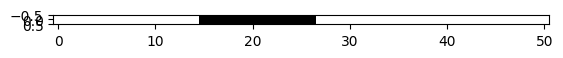

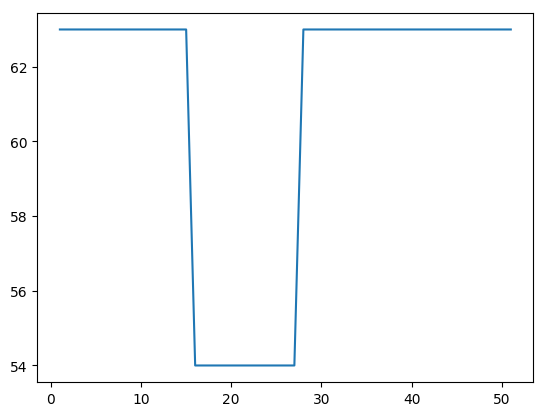

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002F561F60>

In [152]:
# displaying 1D phantom sample
figure(1);imshow(data,cmap="gray", interpolation="none"); # part of PyPlot
figure(2);plot(1:size(data)[2],data[1,:])

In [153]:
size(data)[1]

1

In [154]:
# T2, T1, and proton information. See http://mri-q.com/why-is-t1--t2.html
T2 = 40e-3 #seconds
T1 = 500e-3 #seconds

T2map = zeros(size(data)[1],size(data)[2]);
T2map[:,:] = T2;

T1map = zeros(size(data)[1],size(data)[2]);
T1map[:,:] = T1;

locationX = zeros(1,size(data)[2]);
for cnt = 1: size(data)[2]
    locationX[1,cnt] = cnt;
end

locationY = zeros(1,size(data)[2]);
locationY[:,:] = 1.0;

ProtonDensityMap = data;

### Scan Parameters:
* The field of view (FOV) = 41 mm
* The dwell time (DW) = $50 \ \mu sec$
  * dwell time is the time a the analogue digital converter (ADC) takes to record an amplidue point of the echo signal. This is equivalent to the the time between a amplitude measurement and the successive amplitdue measurement during the total smapling period. Each amplitude measurement correpsonds an instance of addding to the k-space data matrix (remember, not a single k-space point but points althroughout k-space). So if acquiring 256 samples, and the total sampling time at each instance during a pulse sequence was 5.12 ms, then the dwell time would be about 5.12 ms/256 = 20 mu.
* Imaging matrix Size = $ 1 \times 31 $
* Pre-phasing gradient duration (d1) = 5 msec
  * pre-phasing gradient duration is applied prior to excitation gradient an is meant to set phases of the spins to a specific phase (specific point in k-space like k = 0 or a phase = 0 relative to Larmor frequency).
* Echo time (TE) = 50 msec
* Repetition time (TR) = significantly longer than T1 
* The readout bandwidth (BW) = calculated from DW
  * bandwidth is a maeasure frequency breadth (span of frequencies) of singal (some form of information with periodic features). Bandwidth can either describe transmission of a singla or the recieiving of a singal. In this context, the bandwidth describes the recieving of the spin signals, meaning that this bandwidth is defined as the max span of frequencies possible between each sampling point (so 1/dwell time).
* Additional delay time (d2) = determined by TE
  * The total dealy time between the the excitation pulse (making spins all transverse) and the actual image acquistion (as measured from the center of the sampling instance).
* Gradient strength = determined by the FOV and BW

In [160]:
FOV = length(data[1,:]) + 10 #milimeters
DW = 50e-6 #seconds
matrixSize = [size(data)[1],size(data)[2]]
d1 = 5e-3 # pre-phasing gradient duration
TE = 50e-3
TR = 400000e-3
BW = 1/DW # bandwidth of frequencies being recieved
ReadoutAcquisitionWindow = DW*matrixSize[1] # Sampling time at each sampling instance
d2 = TE - (ReadoutAcquisitionWindow/2.)-d1
GradientX = BW/FOV   # Hz/mm
GradientYi = (GradientX*DW)/d1
GradientX1 = -GradientYi*(round(matrixSize[1]/2))
adcStartTime = d1+d2+DW #Acquistion start time
adcEndTime = d1+d2+ReadoutAcquisitionWindow;#Acquistion end time

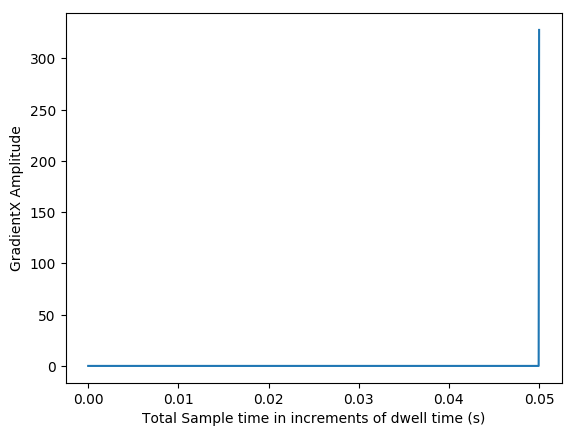

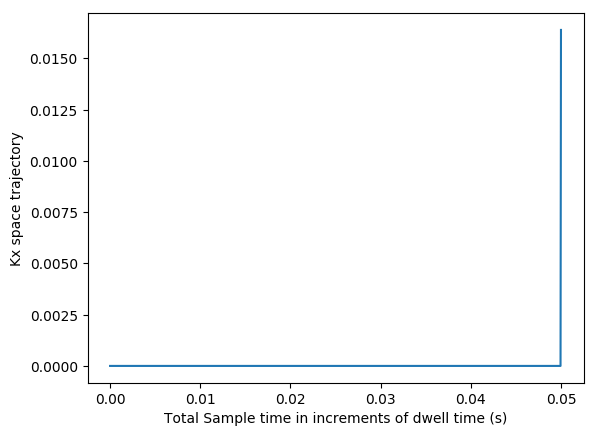

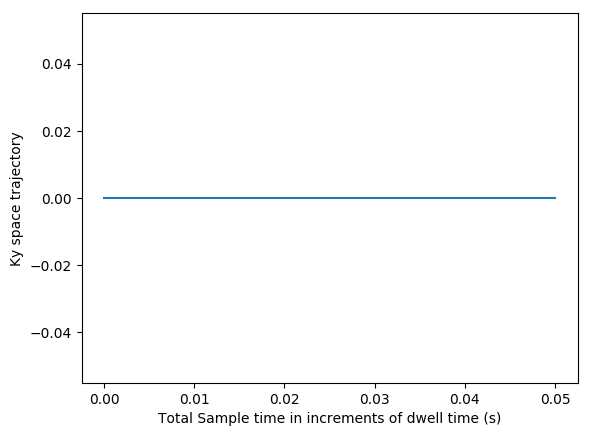

In [161]:
timeSampled = 0:DW:adcEndTime
GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
figure(1); plot(timeSampled,GxWaveform)
xlabel("Total Sample time in increments of dwell time (s)")
ylabel("GradientX Amplitude")
trajectory_kx = cumsum(GxWaveform)*DW;
figure(2); plot(timeSampled,trajectory_kx)
xlabel("Total Sample time in increments of dwell time (s)")
ylabel("Kx space trajectory")
GyWaveform = vcat(0.,0.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
trajectory_ky = cumsum(GyWaveform)*DW;
figure(3); plot(timeSampled,trajectory_ky)
xlabel("Total Sample time in increments of dwell time (s)")
ylabel("Ky space trajectory")
acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

### 1D k-space data at each acquistion time  instance

In [162]:
function MRIscan(t,kx,ky,pd,T2,T1,X,Y)
    kdata = zeros(Complex{Float64},size(t))
    i = complex(0,1)
    for cnt = 1:size(t)[1]
        kdata[cnt]=sum(pd.*exp.(-t[cnt]./T2).*(1.- exp.(-t[cnt]./T1)).*exp.(i*2*π*kx[cnt].*X).*exp.(i*2*π*ky[cnt].*Y))
    end
    return kdata
end

MRIscan (generic function with 1 method)

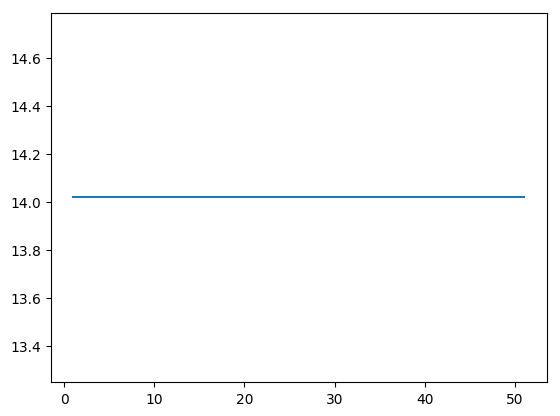

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002F448518>

In [163]:
kdata = MRIscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],T1map[:],locationX[:],locationY[:]);
imgdata = fftshift(fft(fftshift(kdata)));
imgdataPhantom = zeros(Complex{Float64},size(data)[1],size(data)[2]);
imgdataPhantom[1,:]=imgdata[1]
plot(1:size(data)[2],abs.(imgdataPhantom)[1,:])